# Kernel-based Time-varying Regression - Part IV

We will continue to cover advance inputs for KTR. For other details you can also refer to the original paper Ng, Wang and Dai (2021).

In **Part IV**, we will cover advance inputs for regression including

- regressors signs
- adjusting knot sensitivity with respect to volume of response
- time-point coefficients priors 

In [1]:
import pandas as pd
import numpy as np
from math import pi
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTR
from orbit.diagnostics.plot import plot_predicted_components
from orbit.utils.plot import get_orbit_style

%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.5f' % x)
orbit_style = get_orbit_style()
plt.style.context(orbit_style);

In [22]:
from orbit.utils.kernels import gauss_kernel

n = 300
p = 2
tp = np.arange(1, 301) / 300
knot_tp = np.array([1, 100, 300]) / 300
beta_knot = np.array(
    [[1.0, 0.1, 0.15],
     [3.0, 0.01, 0.05],
     [2.0, 0.05, 0.02]]
)

gk = gauss_kernel(tp, knot_tp, rho=0.2)
beta = np.matmul(gk, beta_knot)
covar_lev = np.ones((n, 1))
covar = np.concatenate((covar_lev, np.random.normal(0, 1.0, (n, p))), axis=1)\

# observation with noise
y = (covar * beta).sum(-1) + np.random.normal(0, 0.1, n)


regressor_col = ['x{}'.format(pp) for pp in range(1, p+1)]
data = pd.DataFrame(covar[:,1:], columns=regressor_col)
data['y'] = y
data['date'] = pd.date_range(start='1/1/2018', periods=len(y))
data = data[['date', 'y'] + regressor_col]
beta_col = ['beta{}'.format(pp) for pp in range(1, p+1)]
beta_data = pd.DataFrame(beta[:,1:], columns=beta_col)

data = pd.concat([data, beta_data], axis=1)

In [23]:
data.tail(10)

,date,y,x1,x2,beta1,beta2
290,2018-10-18,1.91233,-0.62762,0.17840,0.04975,0.02019
291,2018-10-19,2.00927,-0.92975,0.81415,0.04976,0.02018
292,2018-10-20,1.96741,0.82438,-0.92705,0.04977,0.02017
293,2018-10-21,2.06355,1.57181,-0.78098,0.04979,0.02016
294,2018-10-22,2.03930,-1.07504,-0.86523,0.04980,0.02015
295,2018-10-23,2.00594,0.24637,-0.98398,0.04981,0.02014
296,2018-10-24,1.91270,-0.58716,0.59911,0.04982,0.02014
297,2018-10-25,1.78525,-2.01610,0.08618,0.04983,0.02013
298,2018-10-26,1.94550,0.33863,-0.37912,0.04984,0.02012
299,2018-10-27,1.90464,-0.96160,-0.42383,0.04985,0.02012


Here, we need to supply additional args to describe the regressors.

In [24]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


## Visualization of Regression Coefficient Curves

First, we can leverage `get_regression_coefs` to extract coefficients with intervals by supplying argument `include_ci=True`.

In [25]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

Let's overlay the estimate with the true coefficients.

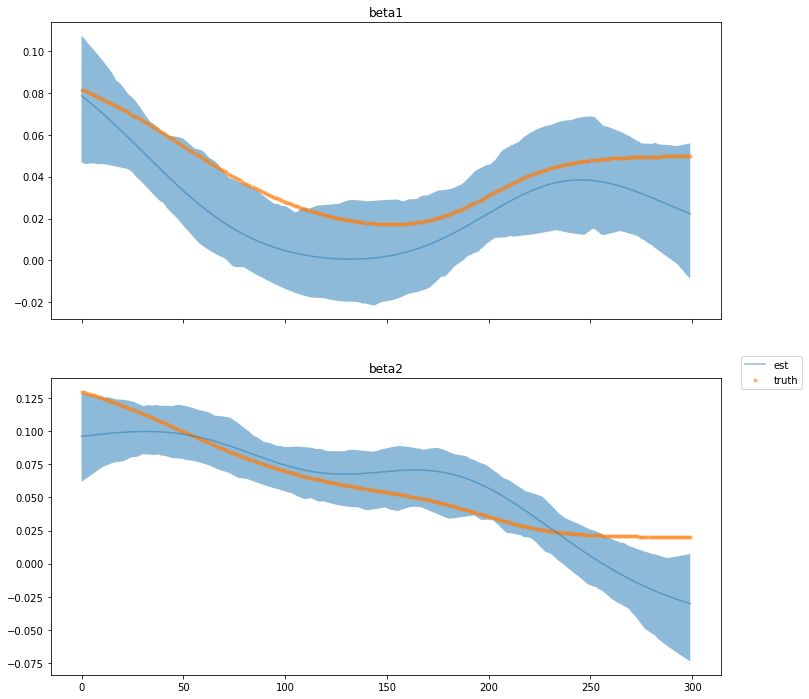

In [27]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));

In [29]:
ktr = KTR(
    response_col='y',
    date_col='date',
    regressor_col=regressor_col,
    regressor_init_knot_scale=[0.1] * p,
    regressor_knot_scale=[0.1] * p,
    regressor_sign=['+'] * p,
    prediction_percentiles=[2.5, 97.5],
    seed=2021,
    estimator='pyro-svi',
)
ktr.fit(df=data)

INFO:root:Guessed max_plate_nesting = 1


In [30]:
coef_mid, coef_lower, coef_upper  = ktr.get_regression_coefs(include_ci=True)

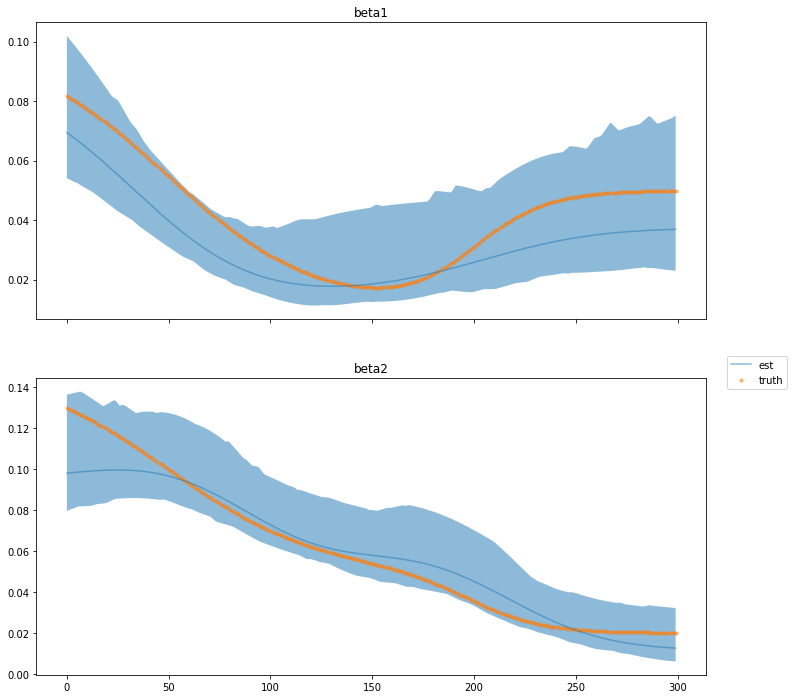

In [31]:
fig, axes = plt.subplots(p, 1, figsize=(12, 12), sharex=True)

x = np.arange(coef_mid.shape[0])
for idx in range(p):
    axes[idx].plot(x, coef_mid['x{}'.format(idx + 1)], label='est' if idx == 0 else "", alpha=0.5)
    axes[idx].fill_between(x, coef_lower['x{}'.format(idx + 1)], coef_upper['x{}'.format(idx + 1)], alpha=0.5)
    axes[idx].scatter(x, data['beta{}'.format(idx + 1)], label='truth' if idx == 0 else "", s=10, alpha=0.5)
    axes[idx].set_title('beta{}'.format(idx + 1))

fig.legend(bbox_to_anchor = (1,0.5));